# BiasAwareGridsearchCV (BAGS) on Diabetes Diagnostics

This project centers on the application of our novel bias-aware GridSearchCV method to mitigate gender-related biases in predictive models using the 2015 CDC Behavioral Risk Factor Surveillance Survey data to predict diabetes likelihood. This innovative approach not only optimizes model accuracy but also prioritizes fairness in predictions. By integrating fairness metrics into the grid search process, we aim to identify model configurations that strike a balance between predictive power and equity, advancing more inclusive healthcare analytics. This advancement represents a crucial step in addressing biases in diabetes prediction, improving both accuracy and fairness in healthcare decision-making.

In [2]:
# imports

import pandas as pd
import numpy as np
import random
import os

# retrieve data
from ucimlrepo import fetch_ucirepo, list_available_datasets

# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

# import data processing
from sklearn.model_selection import train_test_split

# import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# import custom functions
import sys
sys.path.insert(0, '../')

import joblib
import yaml
from util import *
from bias_aware_gridsearch import *

# remove warnings
import warnings
warnings.filterwarnings('ignore')

## Data Ingestion

This Diabetes Health Indicators Dataset from the UCI Machine Learning Repository encompasses healthcare statistics and lifestyle survey data for individuals, alongside their diabetes diagnosis. This data is a condensed form of the  2015 Behavior Risk Factor Surveillace Study (BRFSS) data, collected by the Center for Disease Control through phone surveys. It comprises 35 features, including demographic information, lab test results, and responses to survey questions for each patient. The classification target variable indicates whether a patient is diagnosed with diabetes, pre-diabetic, or healthy.

Codebook containing information on each feature: https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf

In [35]:
# load in data

data = pd.read_csv('diabetes_orig.csv')
data

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Race,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,0.0,5.0,18.0,15.0,1.0,0.0,1.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,1.0,3.0,0.0,0.0,0.0,0.0,1.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,5.0,30.0,30.0,1.0,0.0,1.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,0.0,2.0,0.0,0.0,0.0,0.0,1.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,0.0,2.0,3.0,0.0,0.0,0.0,1.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,0.0,3.0,0.0,5.0,0.0,1.0,6.0,5.0,6.0,7.0
253676,2.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,1.0,0.0,6.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,6.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,0.0,3.0,0.0,0.0,0.0,1.0,6.0,7.0,5.0,1.0


In [67]:
# check for missingness in any features
data.isna().sum()

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Race                    0
Age                     0
Education               0
Income                  0
dtype: int64

## EDA

##### Descriptive statistics

In [57]:
data.shape

(253680, 23)

In [58]:
data.describe()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Race,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.296921,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,2.191414,8.032119,5.050434,6.053875
std,0.698160,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,8.977575,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,1.000000,10.000000,6.000000,8.000000
max,2.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,99.000000,13.000000,6.000000,8.000000


##### Examining distribution of demographic variables

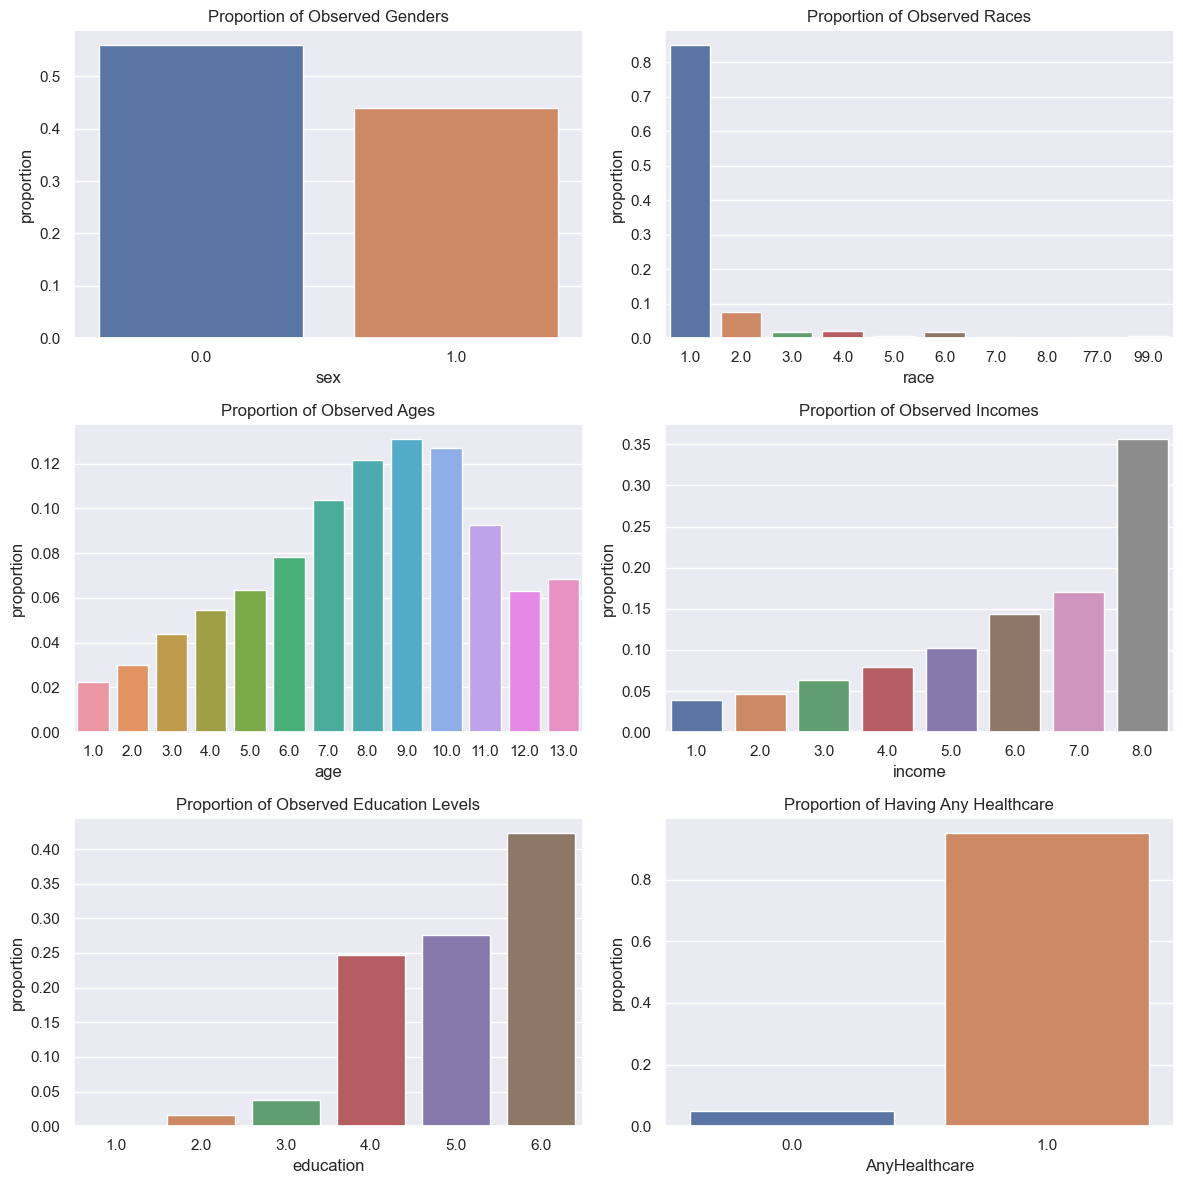

In [121]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# plot gender
prop_sex = data['Sex'].value_counts(normalize=True)
prop_sex_df = pd.DataFrame({'sex': prop_sex.index, 'proportion': prop_sex.values})
sns.barplot(data=prop_sex_df, x='sex', y='proportion', ax = axes[0, 0])
axes[0, 0].set_title("Proportion of Observed Genders")

# plot race
prop_race = data['Race'].value_counts(normalize=True)
prop_race_df = pd.DataFrame({'race': prop_race.index, 'proportion': prop_race.values})
sns.barplot(data=prop_race_df, x='race', y='proportion', ax = axes[0, 1])
axes[0, 1].set_title("Proportion of Observed Races")

# plot age
prop_age = data['Age'].value_counts(normalize=True)
prop_age_df = pd.DataFrame({'age': prop_age.index, 'proportion': prop_age.values})
sns.barplot(data=prop_age_df, x='age', y='proportion', ax=axes[1, 0])
axes[1, 0].set_title("Proportion of Observed Ages")

# plot income
prop_income = data['Income'].value_counts(normalize=True)
prop_income_df = pd.DataFrame({'income': prop_income.index, 'proportion': prop_income.values})
sns.barplot(data=prop_income_df, x='income', y='proportion', ax=axes[1, 1])
axes[1, 1].set_title("Proportion of Observed Incomes")

# plot education levels
prop_education = data['Education'].value_counts(normalize=True)
prop_education_df = pd.DataFrame({'education': prop_education.index, 'proportion': prop_education.values})
sns.barplot(data=prop_education_df, x='education', y='proportion', ax=axes[2, 0])
axes[2, 0].set_title("Proportion of Observed Education Levels")

# plot healthcare status
prop_any_healthcare = data['AnyHealthcare'].value_counts(normalize=True)
prop_any_healthcare_df = pd.DataFrame({'AnyHealthcare': prop_any_healthcare.index, 'proportion': prop_any_healthcare.values})
sns.barplot(data=prop_any_healthcare_df, x='AnyHealthcare', y='proportion', ax=axes[2, 1])
axes[2, 1].set_title("Proportion of Having Any Healthcare")

# show plots
plt.tight_layout()
plt.show()

Upon examining the demographic features provided, it's evident that the dataset comprises a higher proportion of females compared to males, and a notably larger percentage of White participants compared to individuals of other racial backgrounds.


With a relatively equal distribution of sexes in the dataset, we'll focus on sex for de-biasing. Although race is another potential option, its uneven representation presents challenges for training an unbiased model. Therefore, prioritizing sex for de-biasing is considered more feasible and effective in this context.

##### Examining distribution of health and lifestyle variables

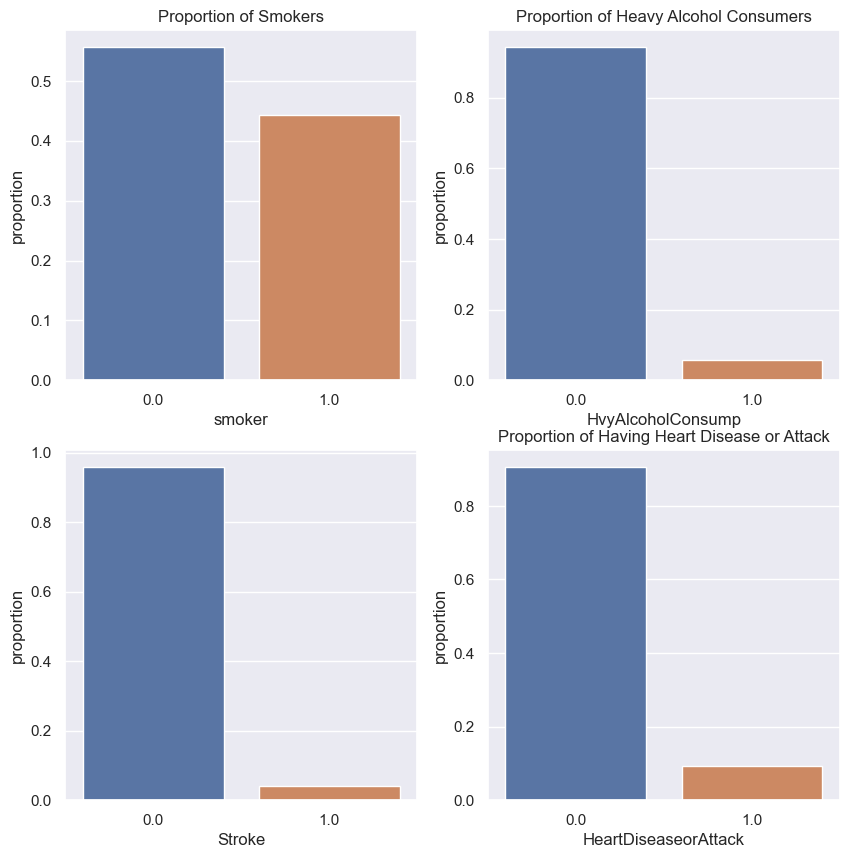

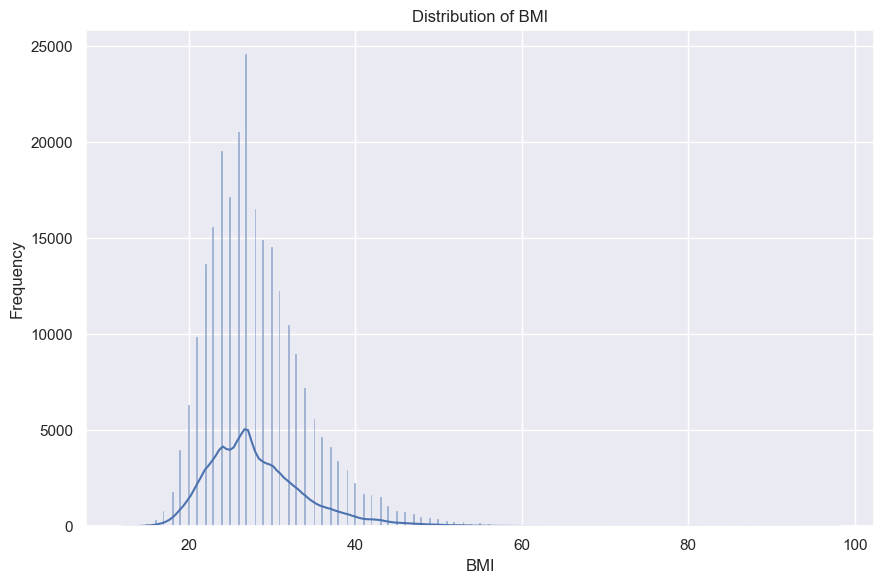

In [122]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))


# plot proportion of smokers
prop_smoker = data['Smoker'].value_counts(normalize=True)
prop_smoker_df = pd.DataFrame({'smoker': prop_smoker.index, 'proportion': prop_smoker.values})
sns.barplot(data=prop_smoker_df, x='smoker', y='proportion', ax=axes[0, 0])
axes[0, 0].set_title("Proportion of Smokers")

# plot proportion of heavy alcohol consumption
prop_hvy_alcohol = data['HvyAlcoholConsump'].value_counts(normalize=True)
prop_hvy_alcohol_df = pd.DataFrame({'HvyAlcoholConsump': prop_hvy_alcohol.index, 'proportion': prop_hvy_alcohol.values})
sns.barplot(data=prop_hvy_alcohol_df, x='HvyAlcoholConsump', y='proportion', ax=axes[0, 1])
axes[0, 1].set_title("Proportion of Heavy Alcohol Consumers") 

# plot proportion of stroke
prop_stroke = data['Stroke'].value_counts(normalize=True)
prop_stroke_df = pd.DataFrame({'Stroke': prop_stroke.index, 'proportion': prop_stroke.values})
sns.barplot(data=prop_stroke_df, x='Stroke', y='proportion', ax=axes[1, 0])
axes[1, 1].set_title("Proportion of Having a Stroke")

# plot proportion of heart disease/attack
prop_heart_disease_attack = data['HeartDiseaseorAttack'].value_counts(normalize=True)
prop_heart_disease_attack_df = pd.DataFrame({'HeartDiseaseorAttack': prop_heart_disease_attack.index, 'proportion': prop_heart_disease_attack.values})
sns.barplot(data=prop_heart_disease_attack_df, x='HeartDiseaseorAttack', y='proportion', ax=axes[1, 1])
axes[1, 1].set_title("Proportion of Having Heart Disease or Attack")

# plot bmi
plt.figure(figsize=(9, 6))
sns.histplot(data=data, x='BMI', kde=True)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')

# show plots
plt.tight_layout()
plt.show()


We are examining the distributions of behavioral and medical features in the dataset to get a general sense of the health and lifestyle of the population surveyed. We can see that almost half of participants are smokers, and approximately 10% of participants have suffered from heart disease or a heart attack, at varying levels of severity.

## Naive Model

The initial step is establishing a baseline Random Forest Classifier to serve as a point of comparison against our hyperparameter-tuned models. With no missingness present in the data, and categorical variables already encoded in numerical form, we can begin model development. Our goal here is to determine whether our model makes predictions regarding whether or not a patient has diabetes in a biased manner based on gender, where our privileged group is males and our unprivileged group is females.

In [59]:
X = data.drop("Diabetes_012", axis=1)
y = data['Diabetes_012']

In [60]:
# split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

# build naive model
model = RandomForestClassifier(random_state=8)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

##### Test Accuracy of Base RF Model

In [61]:
# calculate test accuracy
test_acc = (y_pred == y_test).mean()
print('Testing accuracy:', test_acc)

Testing accuracy: 0.8431291390728477


##### Statistical Parity Difference for Base RF Model

In [34]:
calculate_statistical_parity_difference(data, 'Diabetes_012', 'Sex', 1.0, 0.0, 0.0)

0.021729102970409753

## Naive GridSearch Model

Next, I'll develop a Random Forest Classifier using classic GridSearchCV to serve as a point of comparison against our model after running the novel GridSearch. Due to the large size of the dataset (253,680 rows), running GridSearchCV and our modified BiasAwareGridSearchCV can take significant computational resources and time. For the purposes of reproducibility, I used random sampling to run BAGS on 25,000 rows of the dataset; this sample is representative of the population and the results are therefore likely generalizable. 

In [25]:
# randomly sample 25,000 rows of the data before train, test, split and specify random state for reproducibility

data_sampled = data.sample(n=25000, random_state=42)

X = data_sampled.drop("Diabetes_012", axis=1)
y = data_sampled['Diabetes_012']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

train_data = X_train.join(y_train)

##### Parameters

Next, we establish parameters to feed into our classic and novel GridsearchCV algorithms for tuning. In order to maintain consistency across each test dataset, the parameters are stored in a yaml file and loaded in here. 

In [26]:
parent_dir = os.path.dirname(os.getcwd())
params_path = os.path.join(parent_dir, 'params.yaml')

with open(params_path, 'r') as file:
    param_grid_file = yaml.safe_load(file)
    
param_grid = param_grid_file['detailed_rfc_params']
param_grid

{'n_estimators': [50, 100, 200, 300, 400, 500],
 'max_depth': [20, 40, 50, 100],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [2, 5, 10],
 'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_leaf_nodes': [10, 20, 30, 50, 70, 90, 100],
 'class_weight': ['balanced', 'balanced_subsample']}

In [27]:
model = RandomForestClassifier(random_state=8)

naive_gridsearch = GridSearchCV(model, param_grid, cv=5, n_jobs= -1, verbose=False)
naive_gridsearch.fit(X_train, y_train)
naive_gridsearch = joblib.dump(naive_gridsearch, 'naive_results.pkl')

In [33]:
naive_gridsearch = joblib.load('naive_results.pkl')
naive_model = naive_gridsearch.best_estimator_

In [32]:
# training accuracy and spd

train_pred = naive_model.predict(X_train)
train_res = X_train.copy()
train_res['pred'] = train_pred

print("Accuracy: ", (train_pred == y_train).mean())
print("Statistical parity difference: ", calculate_statistical_parity_difference(train_res, 'pred', 'Sex', 1.0, 0.0, 0.0))

Accuracy:  0.84445
Statistical parity difference:  -0.0019472174597227054


In [31]:
# testing accuracy and spd
test_pred = naive_model.predict(X_test)
test_res = X_test.copy()
test_res['pred'] = test_pred


print("Accuracy: ", (test_pred == y_test).mean())
print("Statistical parity difference: ", calculate_statistical_parity_difference(test_res, 'pred', 'Sex', 1.0, 0.0, 0.0))

Accuracy:  0.8374
Statistical parity difference:  -0.0028766630708377816


Here, we can see that our base Random Forest Classifier had an accuracy of approximately 83.7% when tested on 20% of the dataset. The statistical parity difference here is approximately -0.002, indicating that the resulting model made predictions slightly biased toward our privileged group, males.

## Bias Aware Model

##### Parameters

In [63]:
parent_dir = os.path.dirname(os.getcwd())
params_path = os.path.join(parent_dir, 'params.yaml')

with open(params_path, 'r') as file:
    param_grid_file = yaml.safe_load(file)
    
param_grid = param_grid_file['detailed_rfc_params']
param_grid

{'n_estimators': [50, 100, 200, 300, 400, 500],
 'max_depth': [20, 40, 50, 100],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [2, 5, 10],
 'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_leaf_nodes': [10, 20, 30, 50, 70, 90, 100],
 'class_weight': ['balanced', 'balanced_subsample']}

##### Model Development

In [38]:
# randomly sample 25,000 rows of the data before train, test, split and specify random state for reproducibility

data_sampled = data.sample(n=25000, random_state=42)

X = data_sampled.drop("Diabetes_012", axis=1)
y = data_sampled['Diabetes_012']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

train_data = X_train.join(y_train)

In [39]:
# develop Random Forest models using BAGS and store results in a .pkl file 

model = RandomForestClassifier(random_state=8)

gridsearch = BiasAwareGridSearchCV(model, param_grid, train_sampled, 'Diabetes_012', 'Sex', 1.0, 0.0, 0.0, cv=5, n_jobs= -1, verbose=False)
gridsearch.fit(X_sampled, y_sampled, calculate_statistical_parity_difference)
gridsearch = joblib.dump(gridsearch, 'results.pkl')

In [40]:
gridsearch = joblib.load('results.pkl')

### Model Evaluation

In this investigation, we will explore all models generated by this adapted grid search and examine the relationship between accuracy and bias mitigation.

##### Most Accurate Model

In [42]:
# normal "best accuracy" model - synonymous to regular gridsearchCV's result
rf_accuracy = gridsearch.select_highest_accuracy_model()
rf_accuracy

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=20, max_leaf_nodes=90, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=500, random_state=8)

In [43]:
# training accuracy and spd
train_pred = rf_accuracy.predict(X_train)
train_res = X_train.copy()
train_res['pred'] = train_pred

print("Accuracy: ", (train_pred == y_train).mean())
print("Statistical parity difference: ", calculate_statistical_parity_difference(train_res, 'pred', 'Sex', 1.0, 0.0, 0.0))

Accuracy:  0.83325
Statistical parity difference:  -0.019458418537022015


In [44]:
# testing accuracy and spd
test_pred = rf_accuracy.predict(X_test)
test_res = X_test.copy()
test_res['pred'] = test_pred


print("Accuracy: ", (test_pred == y_test).mean())
print("Statistical parity difference: ", calculate_statistical_parity_difference(test_res, 'pred', 'Sex', 1.0, 0.0, 0.0))

Accuracy:  0.8284
Statistical parity difference:  -0.0346257737149287


This model is equivalent to the optimal model resulting from running regular GridSearchCV. We can see that there is a change in statistical parity difference in the testing data, going from favoring the unprivileged group to slightly favoring our privileged group, males.

##### Least Biased Model

In [45]:
# regardless of accuracy, find which model exhibited lowest training bias
rf_bias = gridsearch.select_least_biased_model()
rf_bias

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=20, max_leaf_nodes=100, min_samples_leaf=2,
                       n_estimators=50, random_state=8)

In [46]:
train_pred = rf_bias.predict(X_train)
train_res = X_train.copy()
train_res['pred'] = train_pred

print("Accuracy: ", (train_pred == y_train).mean())
print("Statistical parity difference: ", calculate_statistical_parity_difference(train_res, 'pred', 'Sex', 1.0, 0.0, 0.0))

Accuracy:  0.83235
Statistical parity difference:  -0.019595158033056115


In [47]:
# testing accuracy and spd
test_pred = rf_bias.predict(X_test)
test_res = X_test.copy()
test_res['pred'] = test_pred


print("Accuracy: ", (test_pred == y_test).mean())
print("Statistical parity difference: ", calculate_statistical_parity_difference(test_res, 'pred', 'Sex', 1.0, 0.0, 0.0))

Accuracy:  0.8244
Statistical parity difference:  -0.021197240853606636


The least biased model has a negligible difference (< 0.005) in accuracy from the most accurate model on testing data, but an approximately 0.014 change in statistical parity difference, getting closer to 0 (which indicates an unbiased model).

###### Balanced Model

In [48]:
# considering the top X accuracy models, select the model with the least exhibited training bias
rf_balance = gridsearch.select_balanced_model(5)
rf_balance

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=20, max_leaf_nodes=90, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=500, random_state=8)

In [49]:
# training accuracy and spd
train_pred = rf_balance.predict(X_train)
train_res = X_train.copy()
train_res['pred'] = train_pred

print("Accuracy: ", (train_pred == y_train).mean())
print("Statistical parity difference: ", calculate_statistical_parity_difference(train_res, 'pred', 'Sex', 1.0, 0.0, 0.0))

Accuracy:  0.83325
Statistical parity difference:  -0.019458418537022015


In [50]:
# testing accuracy and spd
test_pred = rf_balance.predict(X_test)
test_res = X_test.copy()
test_res['pred'] = test_pred


print("Accuracy: ", (test_pred == y_test).mean())
print("Statistical parity difference: ", calculate_statistical_parity_difference(test_res, 'pred', 'Sex', 1.0, 0.0, 0.0))

Accuracy:  0.8284
Statistical parity difference:  -0.0346257737149287


The balanced model here has an almost identical accuracy and statistical parity difference as the most accurate model on the testing data.

##### Optimal Model

In [51]:
# consider the models that had an accuracy within X from the highest accuracy, 
# select the model with the least exhibited bias
rf_optimum = gridsearch.find_optimum_model(50)
rf_optimum

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=20, max_leaf_nodes=100, min_samples_leaf=2,
                       n_estimators=50, random_state=8)

In [52]:
# training accuracy and spd
train_pred = rf_optimum.predict(X_train)
train_res = X_train.copy()
train_res['pred'] = train_pred

print("Accuracy: ", (train_pred == y_train).mean())
print("Statistical parity difference: ", calculate_statistical_parity_difference(train_res, 'pred', 'Sex', 1.0, 0.0, 0.0))

Accuracy:  0.83235
Statistical parity difference:  -0.019595158033056115


In [53]:
# testing accuracy and spd
test_pred = rf_optimum.predict(X_test)
test_res = X_test.copy()
test_res['pred'] = test_pred


print("Accuracy: ", (test_pred == y_test).mean())
print("Statistical parity difference: ", calculate_statistical_parity_difference(test_res, 'pred', 'Sex', 1.0, 0.0, 0.0))

Accuracy:  0.8244
Statistical parity difference:  -0.021197240853606636


The optimum model selected by the BiasAwareGridSearch has a statistical parity difference of approximately -0.02 on the testing data, still indicating a slight bias toward our privileged group. This statistical parity difference is the same value as the parity from the least biased model created.

## Results

The plot below shows the bias and accuracy of all of the models tested during the BiasAwareGridSearch process. The red line indicates the threshold of top models to consider, based on accuracy.

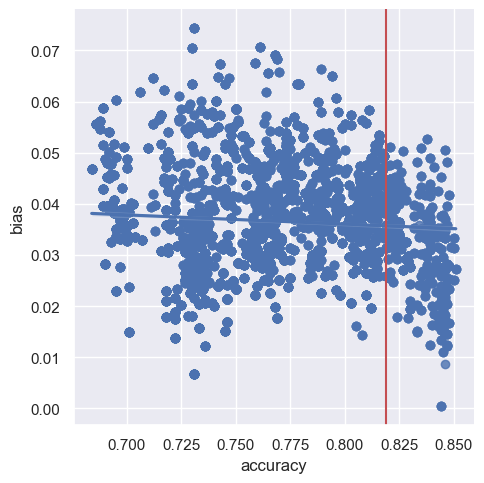

In [70]:
gridsearch.plot_accuracy(1000)

##### Plotting Parameters

We want to explore how the hyperparameters had an influence on the model's improvement in performance, in regards to minimizing bias.

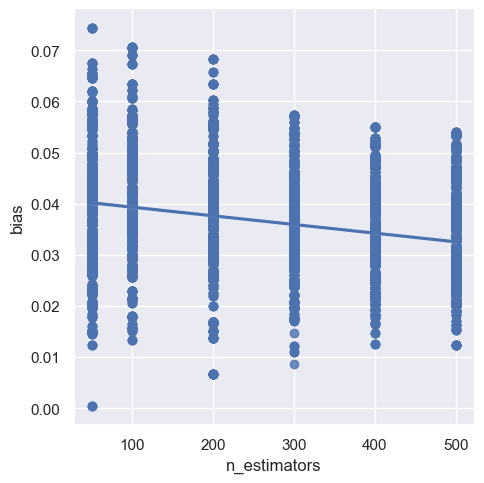

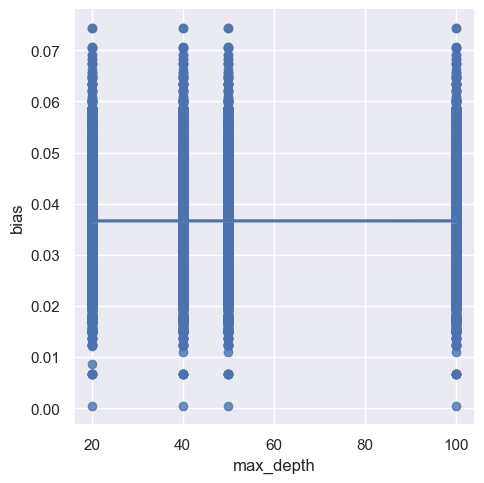

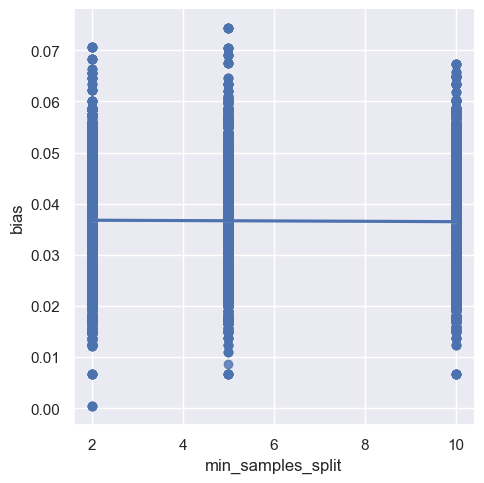

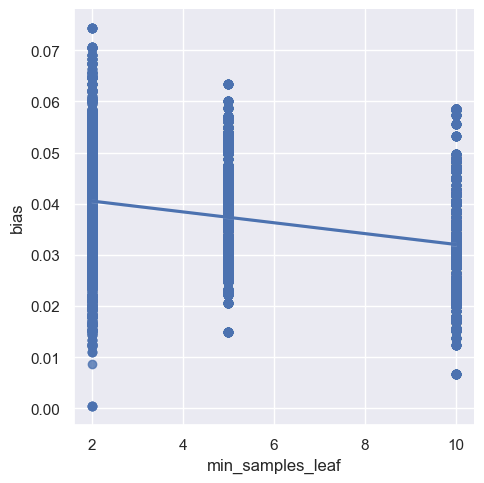

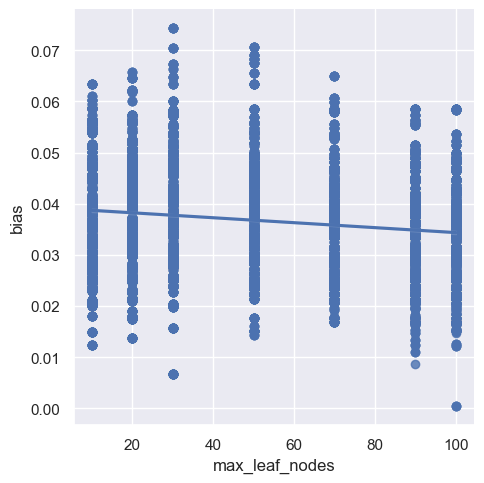

In [71]:
params = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_leaf_nodes']
for param in params:
    gridsearch.plot_params(param)

It appears that n_estimators, min_samples_leaf, and max_leaf_nodes all had an impact on minimizing the bias of our model, whereas the max_depth and min_samples_split of our Random Forest classifier had no effect on bias exhibited. 

## Conclusion

We can see that there is a minimal difference between the statistical parity difference before and after applying our novel BiasAwareGridSearchCV algorithm, which can potentially be attributed to noise and randomness within the dataset and model development pipeline. 

However, graphing the parameters yielded some interesting results: we can see that specific parameters had a significant impact on the outputted bias of the model, while other parameters had absolutely no effect. Furthermore, we can see a correlation between increasing accuracy and minimizing bias, indicating that parameters that decrease bias may also increase the accuracy of predictions. This relationship can be explored in greater depth as a wider variety of parameters are tested.